# Embedding Extraction Example

This notebook shows an example of the pipeline used to extract embeddings from recordings of bird species captured in the Mt Kenya Ecosystem using  Google's [Bird Vocalization Classifier](https://www.kaggle.com/models/google/bird-vocalization-classifier).

## Example Audio
The example recording was obtained at the Dedan Kimathi University of Technology Wildlife Conservancy (DeKUWC) in Nyeri, Kenya using a Raspberry Pi based recorder. It is part of a dataset released here with the accompanying publication "". It contains three species, the Hartlaub's Turaco, Tropical Boubou and Yellow-whiskered Greenbul.

The example has been resampled to 22.05kHz from the orignal wav recording at 16kHz.

In [1]:
import os
import librosa
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import bvc_helper_funcs as bhf

from scipy import signal

2024-04-16 13:06:56.437357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 13:06:56.460095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 13:06:56.460120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 13:06:56.460134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 13:06:56.464359: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 13:06:56.464965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
audio_dir = 'data/wav-22kHz/'
audio_file = '4-2016-01-06-11-15-01.wav'
audio, sampling_rate = librosa.load(os.path.join(audio_dir, audio_file), sr=None)

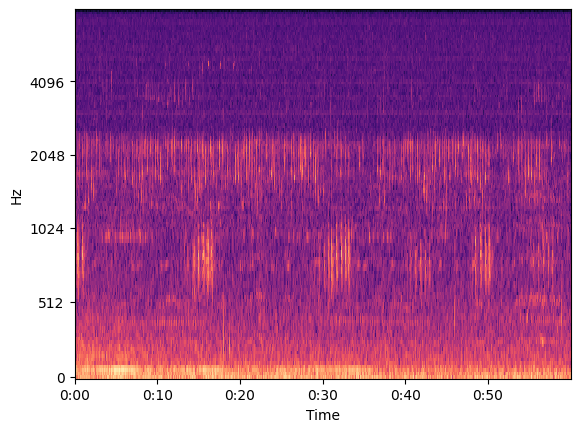

In [3]:
# plot spectrogram
window_ms = 40
hop_ms = 10
window_samples = int((window_ms * sampling_rate) / 1000)
hop_length = int((hop_ms * sampling_rate) / 1000)
n_fft = int(2 ** np.ceil((np.log2(window_samples))))

# compute spectrogram (fmax = 8000 since original is at 16kHz)
S = librosa.feature.melspectrogram(y=audio,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, 
                               x_axis='time',
                               y_axis='mel', 
                               sr=sampling_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               fmax=8000, 
                               ax=ax)

## Source Separation
We attempt to retrieve each component of the audio mixture using models trained on environmental recordings of bird calls with mixture invariant training and made available [here](https://github.com/google-research/sound-separation/tree/master/models/bird_mixit).

In [4]:
cmd = ["python3",
       "sound-separation/models/tools/process_wav.py",
       "--model_dir",
       "bird_mixit_model_checkpoints/output_sources8",
       "--checkpoint",
       "bird_mixit_model_checkpoints/output_sources8/model.ckpt-2178900",
       "--num_sources",
       "8",
       "--input",
       os.path.join(audio_dir, audio_file),
       "--output",
       os.path.join('data/separated-audio/', audio_file)]

subprocess.run(cmd)

2024-04-16 13:06:59.681311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 13:06:59.705459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 13:06:59.705493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 13:06:59.705509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 13:06:59.709850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 13:06:59.709989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

CompletedProcess(args=['python3', 'sound-separation/models/tools/process_wav.py', '--model_dir', 'bird_mixit_model_checkpoints/output_sources8', '--checkpoint', 'bird_mixit_model_checkpoints/output_sources8/model.ckpt-2178900', '--num_sources', '8', '--input', 'data/wav-22kHz/4-2016-01-06-11-15-01.wav', '--output', 'data/separated-audio/4-2016-01-06-11-15-01.wav'], returncode=0)

## Plot Separated Sources

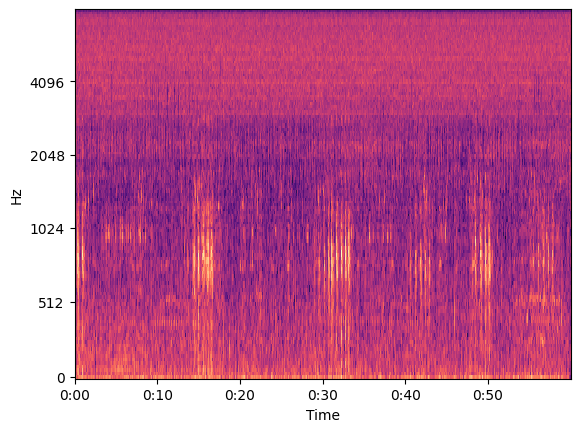

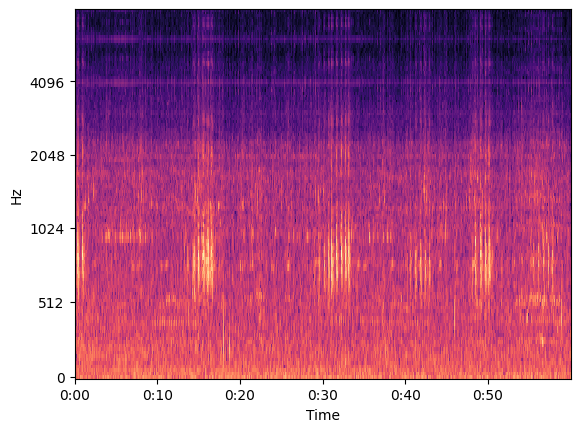

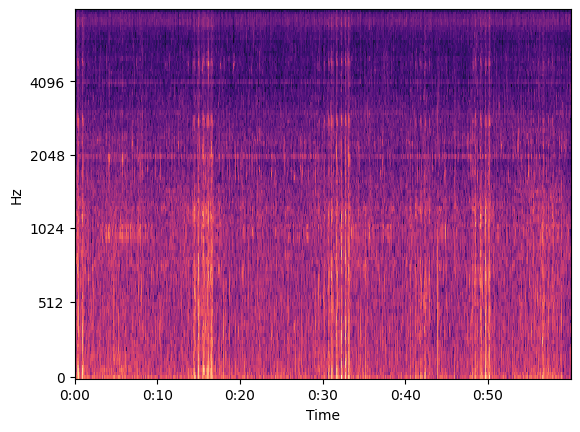

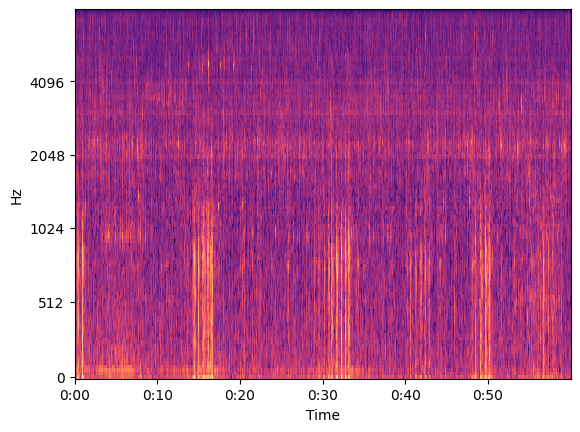

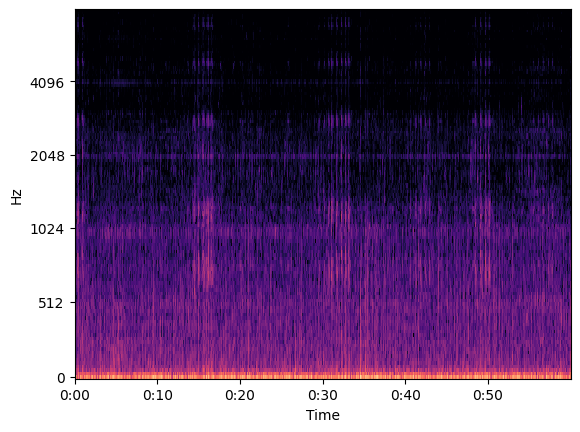

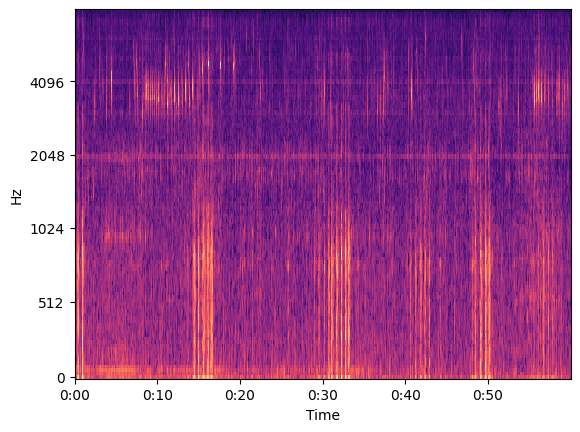

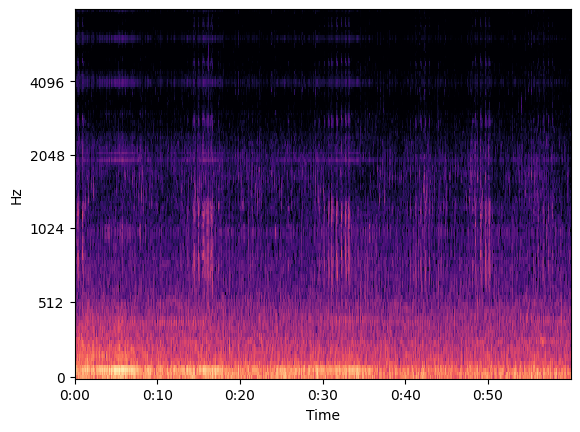

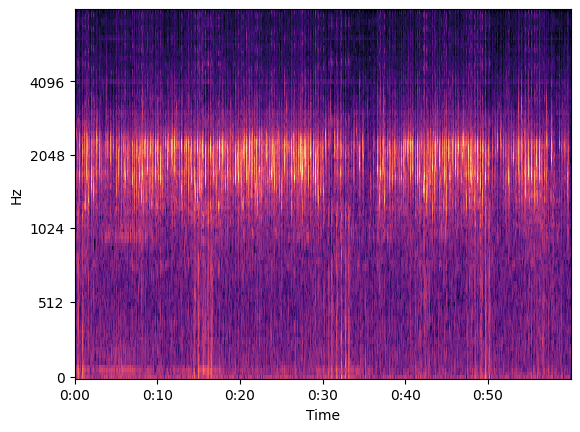

In [5]:
num_sources = 8
for file_indx, file_path in enumerate([os.path.join('data/separated-audio/',
                                                    audio_file.replace('.wav', '_source{}.wav'.format(i))) for i in range(num_sources)]):
    audio, sampling_rate = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=audio,
                                       sr=sampling_rate,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=128,
                                       fmax=8000)
    
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, 
                                   x_axis='time',
                                   y_axis='mel', 
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmax=8000, 
                                   ax=ax)

# Extract Embedding
## Model loading
We extract embeddings by first downloading the model

In [6]:
model, label_paths = bhf.load_model()

2024-04-16 13:07:40.980425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## High Energy Frame Determination
For each file, we determine a region of high energy by using `librosa` to compute frame root mean square energy and using `scipy` to find peaks. We load the files with sampling rate 32kHz which is the native rate for the pretrained models. We extract a 5 second segment centred at selected peaks.

In [7]:
sep_files = [os.path.join('data/separated-audio/',
                          audio_file.replace('.wav', '_source{}.wav'.format(i))) for i in range(num_sources)]
audio, sampling_rate = librosa.load(sep_files[0], sr=32000)

# update parameters for new sampling rate
window_samples = int((window_ms * sampling_rate) / 1000)
hop_length = int((hop_ms * sampling_rate) / 1000)
n_fft = int(2 ** np.ceil((np.log2(window_samples))))

# compute rms
rms = librosa.feature.rms(y=audio,
                          frame_length=n_fft,
                          hop_length=hop_length)
# find peaks
seg_length_ms = 5000 # 5 seconds for use in the model
max_width = int(seg_length_ms / hop_ms)
peakind = signal.find_peaks_cwt(rms[0,:], np.arange(1, max_width))

# energy threshold
energy_quantile = .95
ul = np.quantile(rms, energy_quantile)

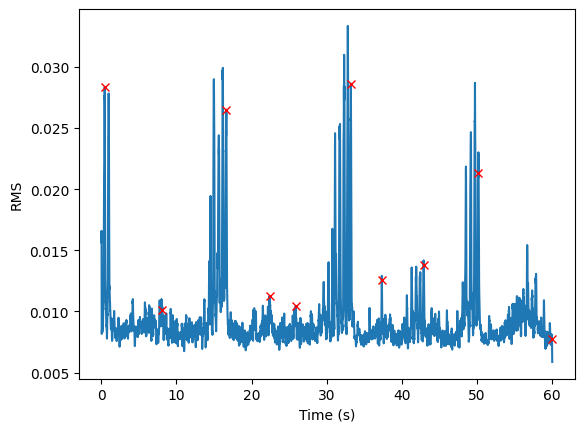

In [8]:
t = librosa.times_like(rms, sr=sampling_rate, hop_length=hop_length)
plt.plot(t, rms.T)
plt.xlabel('Time (s)')
plt.ylabel('RMS')

# plot peaks with energy above threshold
for ind in peakind:
    plt.plot(t[ind], rms[0,ind], 'rx')

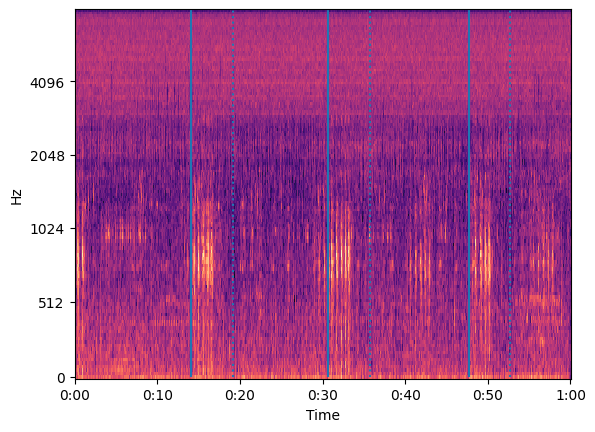

In [9]:
# plot the spectrogram and overlay regions
S = librosa.feature.melspectrogram(y=audio,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, 
                               x_axis='time',
                               y_axis='mel', 
                               sr=sampling_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               fmax=8000, 
                               ax=ax)

for indx in peakind:
    if rms[0, indx] > ul:
        peak_time = (indx * hop_ms) / 1000 
        if peak_time > 2.5:
            ax.vlines(peak_time - 2.5, ymin=0, ymax=8000)
            ax.vlines(peak_time + 2.5, ymin=0, ymax=8000, linestyles ="dotted")


For each 5s segment, we can now extract embeddings.

In [10]:
_, wav_data = bhf.ensure_sample_rate(audio, sampling_rate)

file_embeddings = np.array([])
for indx in peakind:
    if rms[0, indx] > ul:
        peak_time = (indx * hop_ms) / 1000 
        if peak_time > 2.5:
            start_indx = int(np.floor((peak_time - 2.5) * sampling_rate))
            stop_indx = int(np.ceil((peak_time + 2.5) * sampling_rate))
            stop_indx = np.min([stop_indx, len(audio)])

            test_frames = bhf.frame_audio(wav_data[start_indx:stop_indx], hop_size_s=5)

            segment_embedding = bhf.process_audio_frames(test_frames, model)

            if file_embeddings.size:
                file_embeddings = np.vstack((np.array(segment_embedding[0,:]), file_embeddings))
                    
            else:
                file_embeddings = np.array(segment_embedding[0,:])

file_embeddings.shape                    

2024-04-16 13:07:45.542419: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1b06d040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-16 13:07:45.542485: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-16 13:07:45.951816: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 13:07:48.013416: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-16 13:07:48.031372: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


(3, 1280)